In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import diffrax
import genetic_programming as gp
import sympy
import copy
import numpy as np

In [2]:
_itemsize_kind_type = {
    (1, "i"): jnp.int8,
    (2, "i"): jnp.int16,
    (4, "i"): jnp.int32,
    (8, "i"): jnp.int64,
    (2, "f"): jnp.float16,
    (4, "f"): jnp.float32,
    (8, "f"): jnp.float64,
}

def force_bitcast_convert_type(val, new_type=jnp.int32):
    val = jnp.asarray(val)
    intermediate_type = _itemsize_kind_type[new_type.dtype.itemsize, val.dtype.kind]
    val = val.astype(intermediate_type)
    return lax.bitcast_convert_type(val, new_type)

## Environments

In [3]:
class SHO:
    def __init__(self, key, dt, sigma, obs_noise, n_obs):
        self.n_obs = n_obs
        self.n_var = 2
        self.n_control = 1
        self.sigma = sigma
        self.obs_noise = obs_noise

        self.q = self.r = 0.5
        self.Q = jnp.array([[self.q,0],[0,0]])
        self.R = jnp.array([[self.r]])
        
        self.key = key
        self.dt = dt

    def initialize(self, params):
        omega, zeta = params
        self.A = jnp.array([[0,1],[-(omega**2),-zeta]])
        self.b = jnp.array([[0.0,1.0]]).T
        self.G = jnp.array([[0,0],[0,1]])
        self.V = self.sigma*self.G

        self.C = jnp.eye(self.n_var)[:self.n_obs]
        self.W = self.obs_noise*jnp.ones(self.n_obs)

    def f_obs(self,t,x):
        key = jrandom.fold_in(self.key, force_bitcast_convert_type(t))
        return self.C@x + jrandom.normal(key, shape=(self.n_obs,))*self.W

    def compute_riccati(self):
        def riccati(t,S,args):
            return self.A.T@S + S@self.A - S@self.b@(1/self.R)@self.b.T@S + self.Q

        sol = diffrax.diffeqsolve(
                    diffrax.ODETerm(riccati), diffrax.Euler(), 0,10, 0.01, self.Q, max_steps=16**4
                )
        L = 1/self.R@self.b.T@sol.ys[0]
        return L[0]

    def drift(self, t, state, args):
        return self.A@state + self.b@args
    
    def diffusion(self, t, state, args):
        return self.V
    
    def fitness_function(self, state, u, target):
        x_d = jnp.array([target,0])
        u_d = -jnp.linalg.pinv(self.b)@self.A@x_d
        costs = jax.vmap(lambda _state, _u: (_state-x_d).T@self.Q@(_state-x_d) + (_u-u_d)@self.R@(_u-u_d))(state,u)
        return jnp.cumsum(costs)*self.dt
    
    def update_thresholds(self):
        pass

In [4]:
class CartPole:
    def __init__(self, key, dt, sigma, obs_noise, n_obs):
        self.n_obs = n_obs
        self.n_var = 4
        self.n_control = 1
        self.sigma = sigma
        self.obs_noise = obs_noise

        self.threshold_theta = 90 * 2 * jnp.pi / 360
        self.threshold_x = 20
        self.decay = 0.97
        
        self.key = key
        self.dt = dt

    def update_thresholds(self):
        self.threshold_theta *= self.decay
        self.threshold_x *= self.decay

    def initialize(self, params):
        _ = params
        self.g = 9.81
        self.pole_mass = 0.1
        self.pole_length = 0.5
        self.cart_mass = 1
        
        self.G = jnp.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
        self.V = self.sigma*self.G

        self.C = jnp.eye(self.n_var)[:,:self.n_obs]
        self.W = self.obs_noise*jnp.ones(self.n_obs)

    def f_obs(self,t,state):
        key = jrandom.fold_in(self.key, force_bitcast_convert_type(t))
        return self.C@state + jrandom.normal(key, shape=(self.n_obs,))*self.W

    def drift(self, t, state, args):
        control = jnp.squeeze(args)
        x, x_dot, theta, theta_dot = state
        
        theta_acc = (self.g * jnp.sin(theta) + jnp.cos(theta) * (
            -control - self.pole_mass * self.pole_length * theta_dot**2 * jnp.sin(theta)
            ) / (self.cart_mass + self.pole_mass)) / (
                self.pole_length * (4/3 - self.pole_mass * jnp.cos(theta)**2 / (self.cart_mass + self.pole_mass)))
        x_acc = (control + self.pole_mass * self.pole_length * (theta_dot**2 * jnp.sin(theta) - theta_acc * jnp.cos(theta))) / (self.cart_mass + self.pole_mass)

        return jnp.array([
            x_dot,
            x_acc,
            theta_dot,
            theta_acc
        ])
    
    def diffusion(self, t, x, args):
        return self.V
    
    def fitness_function(self, state, u, target):
        u = jnp.squeeze(u)
        x_d = jnp.array([target,0])
        # costs = jax.vmap(lambda _state, _u: (_state[0:2]-x_d).T@self.Q@(_state[0:2]-x_d) + (_state[2:4])@self.S@(_state[2:4]) + (_u)@self.R@(_u))(state,u)*self.dt
        # angle_rewards = jnp.cos(state[:,2])>self.threshold_theta
        angle_rewards = jnp.abs(state[:,2])<self.threshold_theta
        position_rewards = jnp.abs(state[:,0])<self.threshold_x

        costs = jnp.cumsum(1.0-angle_rewards*position_rewards)# - 1e5*jnp.square(u))
        return costs

## Controllers

In [5]:
class LQG:
    def __init__(self, env, mu0, P0):
        self.env = env
        self.mu = mu0

        self.P = P0*self.env.obs_noise

    def solve(self, x0, ts, key, target, params):
        env = copy.copy(self.env)
        env.initialize(params)

        def drift(t, variables, args):
            x_star, u_star = args
            x = variables[:2]
            mu = variables[2:4]
            P = variables[4:].reshape(2,2)
            
            y = env.f_obs(t,x)
            u = jnp.array([-self.L@(mu-x_star) + u_star[0]])
            K = P@env.C.T*(1/env.W)
            # jax.debug.print("L={L}, {Lx}, {Lx2}",L=self.L,Lx= self.L@(mu-x_star), Lx2=self.L@(mu-x_star)*10)
            dx = env.drift(t,x,u)
            dmu = env.A@mu + env.b@u + K@(y-env.C@mu)
            dP = env.A@P + P@env.A.T-K@env.C@P+env.G*env.sigma@env.G
            return jnp.concatenate([dx, dmu, jnp.ravel(dP)])

        #apply process noise only on x
        def diffusion(t, variables, args):
            x = variables[:2]
            return jnp.concatenate([env.diffusion(t,x,args),jnp.zeros((2,2)),jnp.zeros((4,2))])
        
        solver = diffrax.EulerHeun()
        dt0 = 0.005
        saveat = diffrax.SaveAt(ts=ts)

        self.L = env.compute_riccati()

        x_star = jnp.array([target,-0])
        u_star = -jnp.linalg.pinv(env.b)@env.A@x_star 

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(self.env.n_var,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, brownian_motion))

        init = jnp.concatenate([x0, self.mu, jnp.ravel(self.P)])

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star), adjoint=diffrax.DirectAdjoint(), max_steps=16**7
        )

        x = sol.ys[:,:2]
        mu = sol.ys[:,2:4]
        u = jax.vmap(lambda m: -self.L@(m-x_star) + u_star[0])(mu)
        y = jax.vmap(env.f_obs)(ts, x)

        costs = env.fitness_function(x, u, target)

        return x, y, u, mu, costs

In [6]:
class LQR:
    def __init__(self, env):
        self.env = env

    def solve(self, x0, ts, key, target, params):
        env = copy.copy(self.env)
        def drift(t, x, args):
            y = env.f_obs(t,x)
            u = args[1]-self.L@(y-args[0])
            dx = env.drift(t,x,u)
            return dx
            
        #apply process noise only on x
        def diffusion(t, variables, args):
            x = variables[:2]
            return env.diffusion(t,x,args)
    
        solver = diffrax.Euler()
        dt0 = 0.005
        saveat = diffrax.SaveAt(ts=ts)

        env.initialize(params)
        self.L = env.compute_riccati()

        x_star = jnp.array([target,0])
        u_star = -jnp.linalg.pinv(env.b)@env.A@x_star 

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(2,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, brownian_motion))

        init = x0

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star), adjoint=diffrax.DirectAdjoint(), max_steps=16**5
        )

        x = sol.ys
        
        y = jax.vmap(env.f_obs)(ts, x)
        u = u_star-self.L@(y-x_star).T

        costs = env.fitness_function(x, u, target)

        return x, y, u, costs

## GP

In [7]:
def evaluate_lqr(data, env):
    x0, ts, targets, noise_keys, params = data
    
    LQR_control = LQR(env)

    xs_lqr, ys_lqr, us_lqr, costs = jax.vmap(LQR_control.solve, in_axes=[0, None, 0, 0, 0])(x0, ts, noise_keys, targets, params)

    # fig, ax = plt.subplots(ncols=x0.shape[0],nrows=1, figsize=(15,4))
    # ax = ax.ravel()
    # for index in range(x0.shape[0]):
    #     ax[index].plot(ts,xs_lqr[index,:,0], label='$x_1$', color='blue')
    #     ax[index].plot(ts,xs_lqr[index,:,1], label='$x_2$', color='red')
    #     ax[index].plot(ts,ys_lqr[index,:,0], label='$y_1$', alpha=0.5, color='blue')
    #     ax[index].plot(ts,ys_lqr[index,:,1], label='$y_2$', alpha=0.5, color='red')
    #     ax[index].plot(ts,us_lqr[index], label='u', color='green')

    # ax[-1].legend()
    # plt.show()

    return costs, jnp.concatenate([xs_lqr, ys_lqr, jnp.atleast_3d(us_lqr)],axis=2)

def evaluate_lqg(data, env, sample_params):
    mu0, P0 = sample_params
    x0, ts, targets, noise_keys, params = data

    LQG_control = LQG(env, mu0, P0)
    
    xs_lqg, ys_lqg, us_lqg, mu_lqg, costs = jax.vmap(LQG_control.solve, in_axes=[0, None, 0, 0, 0])(x0, ts, noise_keys, targets, params)

    # fig, ax = plt.subplots(ncols=x0.shape[0],nrows=1, figsize=(15,4))
    # ax = ax.ravel()
    # for index in range(x0.shape[0]):
    #     ax[index].plot(ts,xs_lqg[index,:,0], label='$x_1$', color='blue')
    #     ax[index].plot(ts,xs_lqg[index,:,1], label='$x_2$', color='red')
    #     ax[index].plot(ts,ys_lqg[index,:,0], label='$y_1$', alpha=0.5, color='blue')
    #     if env.n_obs==2:
    #         ax[index].plot(ts,ys_lqg[index,:,1], label='$y_2$', alpha=0.5, color='red')
    #     ax[index].plot(ts,us_lqg[index], label='u', color='green')
    # ax[-1].legend()
    # plt.show()

    return costs, (xs_lqg, ys_lqg, us_lqg)

def get_data(N, key, n_var, dt, T, mu0, P0):
    init_key, target_key, noise_key, param1_key, param2_key = jrandom.split(key, 5)
    x0 = mu0 + jrandom.normal(init_key, shape=(N,n_var))@P0
    targets = jrandom.uniform(target_key, shape=(N,), minval=-10, maxval=10)
    noise_keys = jrandom.split(noise_key, N)
    omegas = jrandom.uniform(param1_key, shape=(N,), minval=0.5, maxval=1.5)
    zetas = jrandom.uniform(param2_key, shape=(N,), minval=0.0, maxval=0.5)
    ts = jnp.arange(0,T,dt)
    # omegas = jnp.ones(N)
    params = omegas, zetas
    return x0, ts, targets, noise_keys, params

In [8]:
def get_lqg_solution(gp, params, env):
    def my_to_string(sol):
        expr = sympy.parsing.sympy_parser.parse_expr(sol,evaluate=True)
        return gp.simplify_algebra(gp.reconstruct(expr,mode="Mul"))[0]

    L = jnp.array([0.41420195, 0.91019833])
    sigma = env.obs_noise
    omega = params[0]**2
    v = env.sigma

    K1 = f'a2/{sigma}'
    K2 = f'a4/{sigma}'
    a0 = f'a1 + {K1}*(y0-a0)' #mu1
    a1 = f'-{omega}*a0 + u0 + {K2}*(y0-a0)' #mu2
    a2 = f'a4 + a3 - {K1}*a2' #P11
    a3 = f'a5 - {omega}*a2 - {K1}*a4' #P12
    a4 = f'-{omega}*a2 + a4 - {K2}*a2' #P21
    a5 = f'-{omega}*a3 - {omega}*a4 + {v} - {K2}*a4' #P22
    readout = f'-{L[0]}*(a0-target)-{L[1]}*a1+{omega}*target'

    lqg_sol = gp.Expression([my_to_string(a0),my_to_string(a1),my_to_string(a2),my_to_string(a3),my_to_string(a4),my_to_string(a5)], my_to_string(readout))

    return lqg_sol

In [9]:
T = 150
dt = 0.5

sigma = 0.01
obs_noise = 0.1

# mu0 = jnp.array([0,0,0,0])
# P0 = jnp.eye(4)*jnp.array([0.05,0.01,0.05,0.01])

mu0 = jnp.zeros(2)
P0 = jnp.eye(2)

In [10]:
generations = 50
n_seeds = 1

best_fitnesses = []
best_solutions = []
rs_best_fitnesses = []
rs_best_solutions = []
all_costs_lqr = []
all_costs_lqg = []

for seed in range(0,n_seeds):
    key = jrandom.PRNGKey(seed)
    env_key, data_key, gp_key = jrandom.split(key, 3)

    env = SHO(env_key, dt, sigma, obs_noise, n_obs=1)
    # env = CartPole(env_key, dt, sigma, obs_noise, n_obs=4)

    data = get_data(50, data_key, env.n_var, dt, T, mu0, P0)

    # costs_lqr, state_obs_control_lqr = evaluate_lqr(validation_data, env, (datasampler.mu0, datasampler.P0))
    # final_cost_lqr=jnp.mean(costs_lqr[:,-1], axis=0)*dt
    # all_costs_lqr.append(final_cost_lqr)
    # print("Optimal cost LQR: ", final_cost_lqr)

    costs_lqg, state_obs_control_lqg = evaluate_lqg(data, env, (mu0, P0))
    final_cost_lqg=jnp.mean(costs_lqg[:,-1], axis=0)*dt
    all_costs_lqg.append(final_cost_lqg)
    
    print("Optimal cost LQG: ", final_cost_lqg)
    gp = gp.ODE_GP(seed, state_size=1, population_size=200, num_populations=4, max_depth=8, max_init_depth=4)

#     # lqg_solution = get_lqg_solution(gp, data[-1], env)

    best_fitness, best_solution, final_population = gp.run(env, data, generations, pool_size=10, converge_value=0)
#     # print("random search")
#     # rs_best_fitness, rs_best_solution, rs_final_population = gp.random_search(env, data, generations, pool_size=10, converge_value=converge_value)
    
    best_fitnesses.append(best_fitness)
    best_solutions.append(best_solution)
    # rs_best_fitnesses.append(rs_best_fitness)
    # rs_best_solutions.append(rs_best_solution)
    
best_fitnesses = jnp.array(best_fitnesses).reshape(n_seeds, generations)

# rs_best_fitnesses = jnp.array(rs_best_fitnesses).reshape(n_seeds, generations)

Optimal cost LQG:  12.071268
In generation 1, average fitness: 656095.0, best_fitness: 2564.320068359375, best solution: [-a0 + target], readout: a0
In generation 2, average fitness: 389166.40625, best_fitness: 2008.7288818359375, best solution: [target*y0 + 13.3184938999482], readout: 0.4618206*target
In generation 3, average fitness: 301090.34375, best_fitness: 2008.7288818359375, best solution: [target*y0 + 13.3184938999482], readout: 0.4618206*target
In generation 4, average fitness: 284500.71875, best_fitness: 1826.4090576171875, best solution: [0.652160146793423*a0 + 1.1384878/y0], readout: 0.7739684*target
In generation 5, average fitness: 277132.46875, best_fitness: 1826.4090576171875, best solution: [0.652160146793423*a0 + 1.1384878/y0], readout: 0.7739684*target
In generation 6, average fitness: 274469.5625, best_fitness: 1728.0240478515625, best solution: [target], readout: 0.68751395*target
In generation 7, average fitness: 293838.875, best_fitness: 1725.9599609375, best so

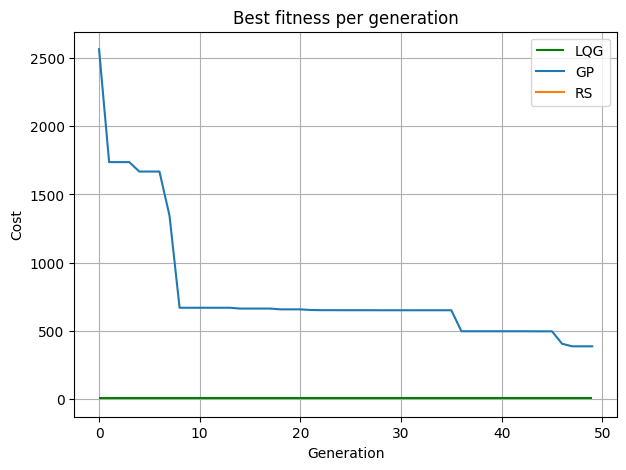

In [ ]:
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

mean_fitnesses = jnp.mean(best_fitnesses, axis=0)
std_fitnesses = jnp.std(best_fitnesses, axis=0)

# rs_mean_fitnesses = jnp.mean(rs_best_fitnesses[1:], axis=0)
# rs_std_fitnesses = jnp.std(rs_best_fitnesses[1:], axis=0)

plt.plot(jnp.arange(generations), mean_fitnesses, color=f'C0')
# plt.fill_between(jnp.arange(generations), mean_fitnesses-std_fitnesses, mean_fitnesses+std_fitnesses, color='C0', alpha=0.3)
# plt.plot(jnp.arange(generations), rs_mean_fitnesses, color=f'C1')
# plt.fill_between(jnp.arange(generations), rs_mean_fitnesses-rs_std_fitnesses, jnp.clip(rs_mean_fitnesses+rs_std_fitnesses,None,0), color='C1', alpha=0.3)
# plt.hlines(jnp.mean(jnp.array(all_costs_lqr))*dt, 0, generations-1, color="red", label='LQR')
plt.hlines(jnp.mean(jnp.array(all_costs_lqg))*dt, 0, generations-1, color="green", label='LQG')
plt.plot(0, 0, label=f"GP", color="C0")
plt.plot(0, 0, label=f"RS", color="C1")
plt.title("Best fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Cost")
plt.legend()
ax.grid('on')

# plt.ylim(jnp.mean(jnp.array(all_costs_lqg))*dt*0.8,max(jnp.mean(jnp.array(all_costs_lqr))*dt*1.1,mean_fitnesses[-1]*1.1))
# plt.ylim(jnp.mean(jnp.array(all_costs_lqg))*dt*0.8,jnp.mean(jnp.array(all_costs_lqg))*dt*2)
plt.show()

In [ ]:
def my_to_string(sol):
    expr = sympy.parsing.sympy_parser.parse_expr(sol,evaluate=True)
    return gp.sympy_to_tree(expr,mode="Mul")

In [ ]:
# test_T = 100
# dt = 0.5
# seed = 0

# test_data, sample_params, env = get_data(seed, T=test_T, dt=dt)
# costs_lqg, state_obs_control_lqg = evaluate_lqg(test_data, env, sample_params)
# print("hoi")
# x0,ts,targets,noise_keys,params=test_data
# gp = gp.ODE_GP(seed, state_size=6)
# gp.initialize_variables(env)

# #LQG:
# L = jnp.array([0.41420195, 0.91019833])
# sigma = env.obs_noise
# omega = params[0]**2
# v = env.sigma

# K1 = f'a2/{sigma}'
# K2 = f'a4/{sigma}'
# a0 = f'a1 + {K1}*(y0-a0)' #mu1
# a1 = f'-{omega}*a0 + u0 + {K2}*(y0-a0)' #mu2
# a2 = f'a4 + a3 - {K1}*a2' #P11
# a3 = f'a5 - {omega}*a2 - {K1}*a4' #P12
# a4 = f'-{omega}*a2 + a5 - {K2}*a2' #P21
# a5 = f'-{omega}*a3 - {omega}*a4 + {v} - {K2}*a4' #P22
# readout = f'-{L[0]}*(a0-target)-{L[1]}*a1+{omega}*target'

# lqg_sol = gp.Expression([my_to_string(a0),my_to_string(a1),my_to_string(a2),my_to_string(a3),my_to_string(a4),my_to_string(a5)], my_to_string(readout))
# xs_gp, ys_gp, us_gp, _, costs_gp = jax.vmap(gp.evaluate_control_loop, in_axes=[None,0,None, 0, 0, 0])(lqg_sol, x0, ts, targets, noise_keys, params)

# fig, ax = plt.subplots(ncols=4,nrows=5, figsize=(25,18))
# ax = ax.ravel()

# for i in range(x0.shape[0]):
#     index = 2*i
#     ax[index].plot(ts,xs_gp[i,:,0], label='$x_1$', color='blue')
#     ax[index].plot(ts,xs_gp[i,:,1], label='$x_2$', color='red')
#     ax[index].plot(ts,ys_gp[i,:,0], label='$y_1$', alpha=0.5, color='blue')
#     if ys_gp.shape[-1]==2:
#         ax[index].plot(ts,ys_gp[i,:,1], label='$y_2$', alpha=0.5, color='red')
#     ax[index].plot(ts,us_gp[i], label='u', color='green')
#     ax[index].hlines(targets[i], ts[0], ts[-1], color="black", linestyle="--", label="Target")
#     ax[index].set_title("GP")

#     ax[index+1].plot(ts,state_obs_control_lqg[i,:,0], label='$x_1$', color='blue')
#     ax[index+1].plot(ts,state_obs_control_lqg[i,:,1], label='$x_2$', color='red')
#     ax[index+1].plot(ts,state_obs_control_lqg[i,:,2], label='$y_1$', alpha=0.5, color='blue')
#     ax[index+1].plot(ts,state_obs_control_lqg[i,:,3], label='$y_2$', alpha=0.5, color='red')
#     ax[index+1].plot(ts,state_obs_control_lqg[i,:,4], label='u', color='green')
#     ax[index+1].hlines(targets[i], ts[0], ts[-1], color="black", linestyle="--", label="Target")
#     ax[index+1].set_title('LQG')
# ax[-1].legend()
# plt.show()

# mean_costs_lqg = jnp.mean(costs_lqg*dt, axis=0)
# std_costs_lqg = jnp.std(costs_lqg*dt, axis=0)*dt

# plt.plot(ts, mean_costs_lqg, label='LQG', color=f'C0')
# plt.fill_between(ts, mean_costs_lqg-std_costs_lqg,  mean_costs_lqg+std_costs_lqg, color='C0', alpha=0.3)

# mean_costs_gp = jnp.mean(costs_gp*dt, axis=0)
# std_costs_gp = jnp.std(costs_gp*dt, axis=0)*dt

# plt.plot(ts, mean_costs_gp, label=f'GP', alpha=1., color=f'C1')
# plt.fill_between(ts, mean_costs_gp-std_costs_gp,  mean_costs_gp+std_costs_gp, color='C1', alpha=0.3)

# # mean_costs_lqr = jnp.mean(costs_lqr*dt, axis=0)
# # std_costs_lqr = jnp.std(costs_lqr*dt, axis=0)*dt

# # plt.plot(ts, mean_costs_lqr, label='LQR', color=f'C2')
# # plt.fill_between(ts, mean_costs_lqr-std_costs_lqr,  mean_costs_lqr+std_costs_lqr, color='C2', alpha=0.3)

# plt.xlabel('time t')
# plt.ylabel('cost')
# plt.title('Cumulative cost of best solution')
# plt.legend()
# plt.show()

state equations:  [-1.0*a0 + y0 + 2.7877536*y1]  readout:  -a0 + 2*target + 0.027069688
117.75475


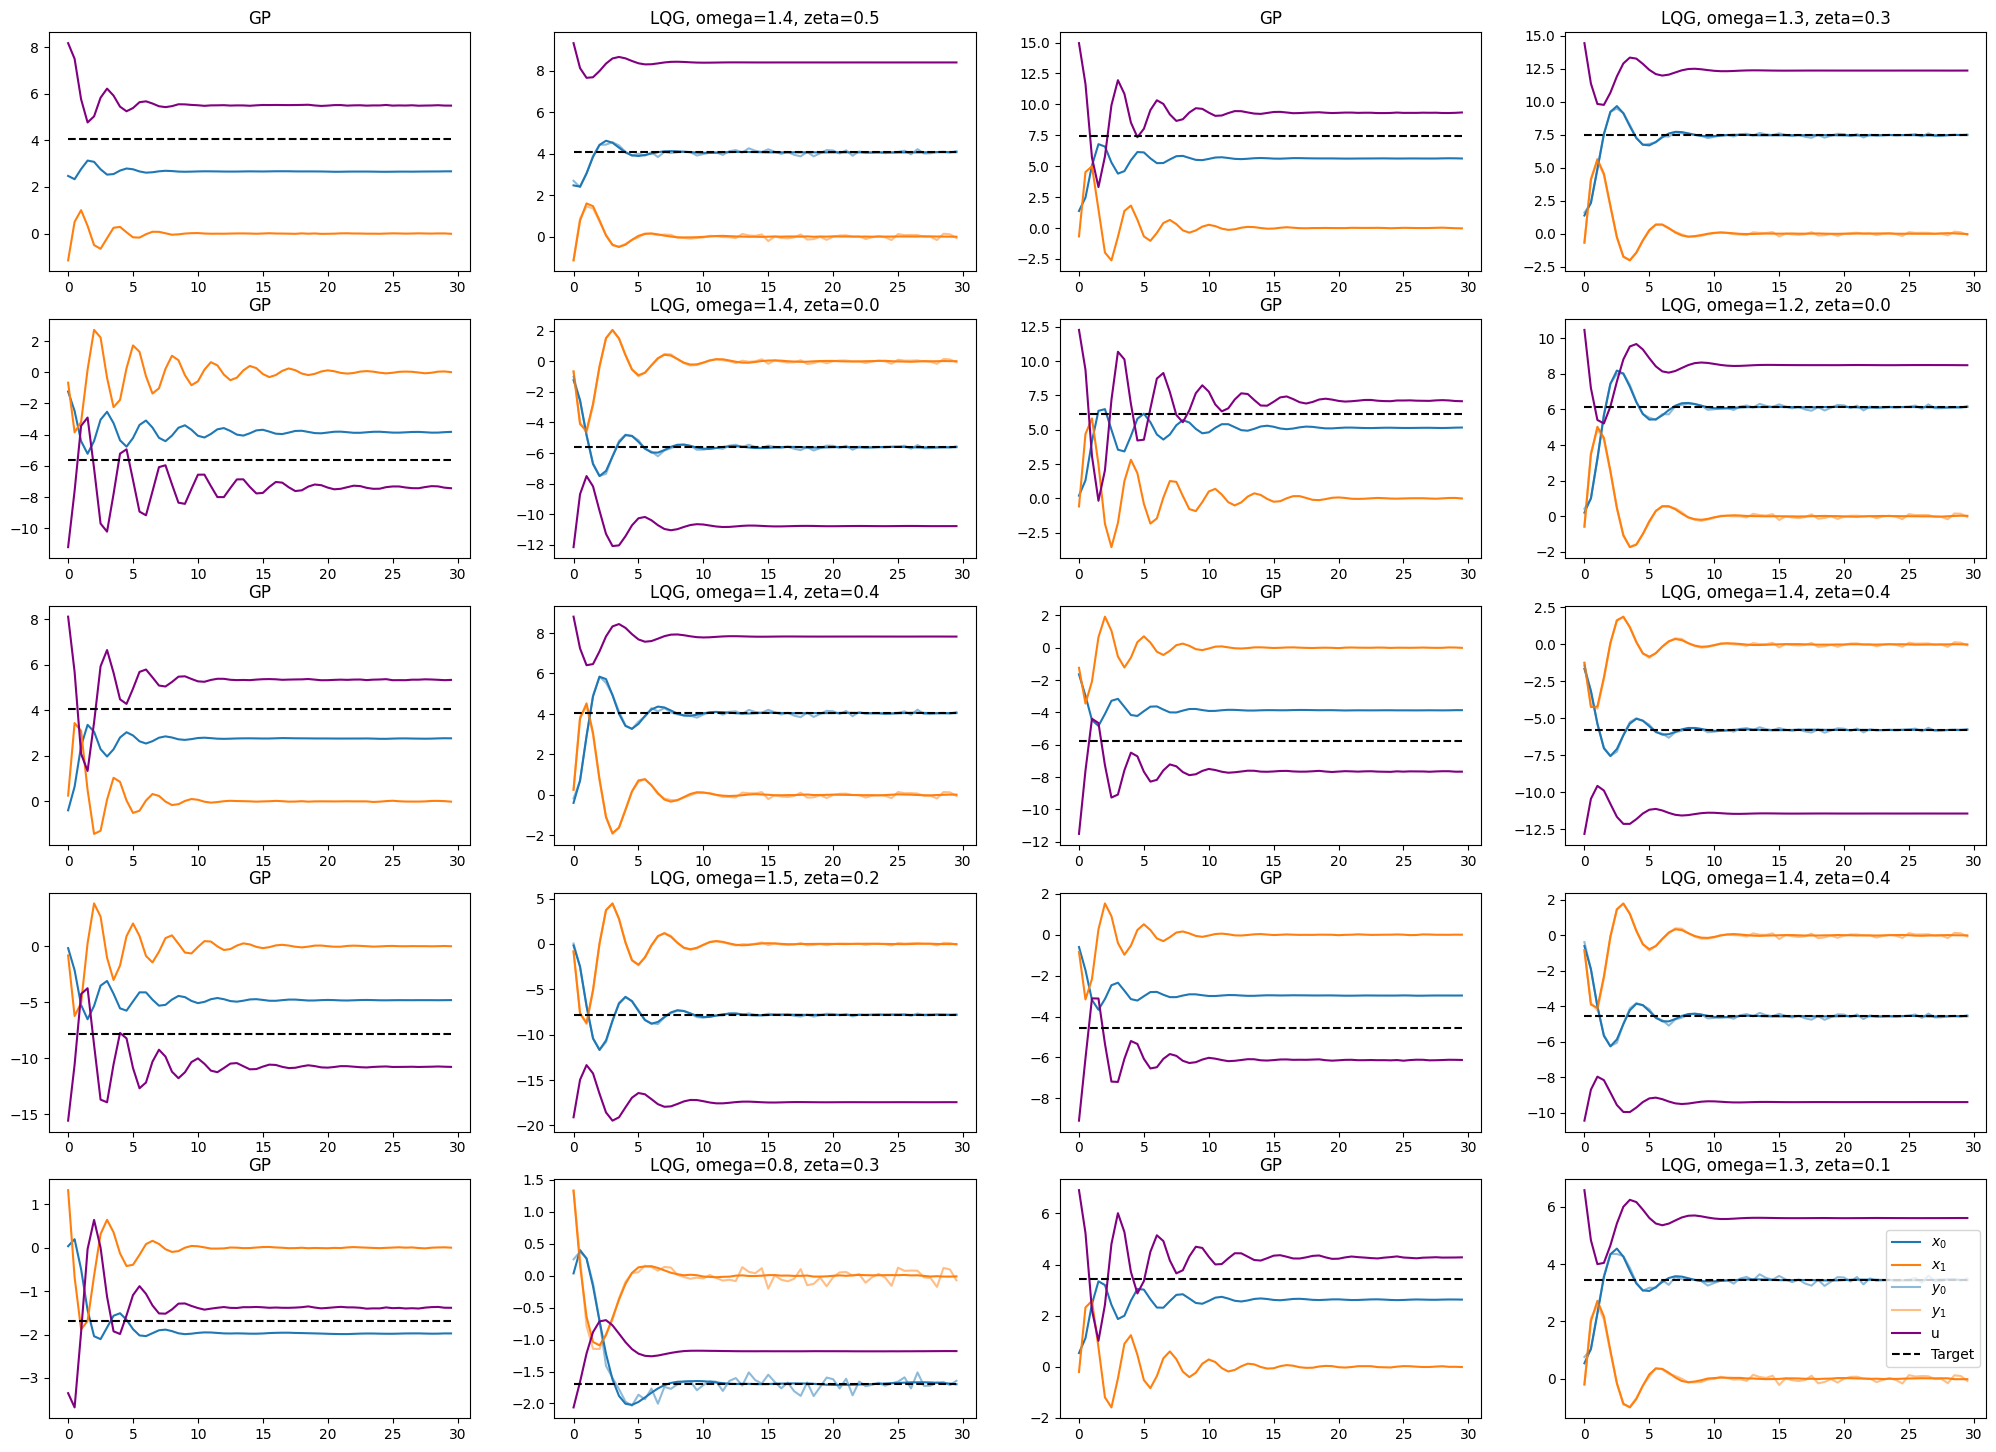

In [ ]:
def plot(test_data, env, model, gp, plot_lqg=False):
    test_x0, test_ts, test_targets, test_noise_keys, test_params = test_data
    if plot_lqg:
        test_costs_lqg, test_state_obs_control_lqg = evaluate_lqg(test_data, env, (mu0, P0))
        xs_lqg, ys_lqg, us_lqg = test_state_obs_control_lqg
        
        fig, ax = plt.subplots(ncols=4,nrows=5, figsize=(25,18))
    else:
        fig, ax = plt.subplots(ncols=2,nrows=5, figsize=(25,18))

    print("state equations: ", gp.trees_to_sympy(model)," readout: ",gp.tree_to_sympy(model.readout_tree))
    xs_gp, ys_gp, us_gp, _, costs_gp = jax.vmap(gp.evaluate_control_loop, in_axes=[None,0,None, 0, 0, 0])(model, test_x0, test_ts, test_targets, test_noise_keys, test_params)
    
    ax = ax.ravel()
    plot_indices = [0,1]

    print(jnp.mean(costs_gp[:,-1])*dt)

    for i in range(10):
        if plot_lqg:
            index = 2*i
        else:
            index = i

        for j in plot_indices:
            if j == 2:
                ax[index].plot(test_ts,jnp.cos(xs_gp[i,:,j]), label=f'$x_{j}$', color=f'C{j}')
            else:
                ax[index].plot(test_ts,xs_gp[i,:,j], label=f'$x_{j}$', color=f'C{j}')
        # for j in range(env.n_obs):
        #     ax[index].plot(test_ts,ys_gp[i,:,j], label=f'$y_{j}$', alpha=0.5, color=f'C{j}')
        ax[index].plot(test_ts,us_gp[i], label='u', color='purple')
        # ax[index].hlines(env.threshold_theta, test_ts[0], test_ts[-1], color="black", linestyle="--", label="Target")
        ax[index].hlines(test_targets[i], test_ts[0], test_ts[-1], color="black", linestyle="--", label="Target")
        ax[index].set_title(f"GP")#, omega={test_params[i]:.1f}")
        # ax[index].set_ylim(-5, 5)

        if plot_lqg:
            for j in range(env.n_var):
                ax[index+1].plot(test_ts,xs_lqg[i,:,j], label=f'$x_{j}$', color=f'C{j}')
            for j in range(env.n_obs):
                ax[index+1].plot(test_ts,ys_lqg[i,:,j], label=f'$y_{j}$', alpha=0.5, color=f'C{j}')
            ax[index+1].plot(test_ts,us_lqg[i], label='u', color='purple')
            ax[index+1].hlines(test_targets[i], test_ts[0], test_ts[-1], color="black", linestyle="--", label="Target")
            ax[index+1].set_title(f"LQG, omega={test_params[0][i]:.1f}, zeta={test_params[1][i]:.1f}")
            # ax[index+1].set_ylim(test_targets[i]-0.5, test_targets[i]+0.5)
    ax[-1].legend()
    plt.show()

    return xs_gp, us_gp

test_T = 30
seed = 11
key = jrandom.PRNGKey(seed)
env_key, data_key, gp_key = jrandom.split(key, 3)

env = SHO(env_key, dt, sigma, obs_noise, n_obs=2)
# env = CartPole(env_key, dt, sigma, obs_noise, n_obs=4)

test_data = get_data(10, data_key, env.n_var, dt, test_T, mu0=mu0, P0=P0)

gp = gp.ODE_GP(seed, state_size=1, population_size=100, num_populations=4, max_depth=8, max_init_depth=4)
gp.initialize_variables(env)
model=best_solutions[0]
# model = gp.NetworkTrees([my_to_string('19.2769000445696*target - 1.85618655557819*u0 - 16.4508231334412*y0 - 36.6833155757251*y1')], my_to_string('a0'))
# model = gp.NetworkTrees([my_to_string('0.38799737868971*target')], my_to_string('30*y2 + y3'))
# model = gp.NetworkTrees([my_to_string('-2.9977148*a0 + 2.0*target - 1.4817132*y0 - 2.0*y1')],my_to_string('0*6.77732*a0'))

x, u = plot(test_data, env, model, gp, plot_lqg=True)

In [ ]:
test_data[4]

(Array([1.4375203, 1.2870903, 1.3842937, 1.1772132, 1.3910179, 1.4065207,
        1.4944444, 1.435862 , 0.8366537, 1.2758238], dtype=float32),
 Array([0.49692756, 0.2908051 , 0.01485258, 0.04688036, 0.42125213,
        0.3553092 , 0.18488961, 0.4305932 , 0.33423138, 0.11357915],      dtype=float32))

NameError: name 'test_costs_lqg' is not defined

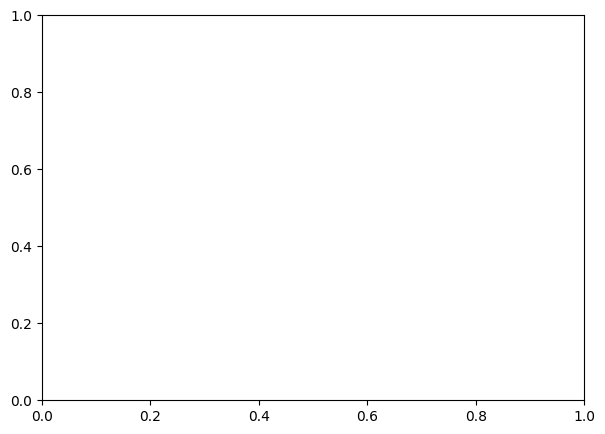

In [ ]:
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

mean_costs_lqg = jnp.mean(test_costs_lqg*dt, axis=0)
std_costs_lqg = jnp.std(test_costs_lqg*dt, axis=0)

plt.plot(test_ts, mean_costs_lqg, label='LQG', color=f'C2')
plt.fill_between(test_ts, mean_costs_lqg-std_costs_lqg,  mean_costs_lqg+std_costs_lqg, color='C2', alpha=0.3)

mean_costs_gp = jnp.mean(costs_gp*dt, axis=0)
std_costs_gp = jnp.std(costs_gp*dt, axis=0)

plt.plot(test_ts, mean_costs_gp, label=f'GP', alpha=1., color=f'C0')
plt.fill_between(test_ts, mean_costs_gp-std_costs_gp,  mean_costs_gp+std_costs_gp, color='C0', alpha=0.3)

plt.xlabel('t')
plt.ylabel('cost')
plt.title('Cumulative cost of best solution')
plt.legend()
ax.grid()
plt.show()

In [ ]:
print(error)
name = 'obs_random_env'
np.save(f'data_files/{name}/best_fitnesses.npy',best_fitnesses)
np.save(f'data_files/{name}/rs_best_fitnesses.npy',rs_best_fitnesses)
np.save(f'data_files/{name}/best_solutions.npy',best_solutions)
np.save(f'data_files/{name}/lqg.npy',jnp.array(all_costs_lqg))

In [ ]:
bf = np.load('data_files/observable_1_env/best_fitnesses.npy')
rbf = np.load('data_files/observable_1_env/rs_best_fitnesses.npy')
bs = np.load('data_files/observable_1_env/best_solutions.npy', allow_pickle=True)
lqg = np.load('data_files/observable_1_env/lqg.npy')
n_seeds = len(bf)
generations = len(bf[0])
dt = 0.5

import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

mean_fitnesses = jnp.mean(bf, axis=0)
std_fitnesses = jnp.std(bf, axis=0)

rs_mean_fitnesses = jnp.mean(rbf, axis=0)
rs_std_fitnesses = jnp.std(rbf, axis=0)
plt.hlines(jnp.mean(lqg)*dt, 0, generations-1, color="C2", label='Linear Quadratic Gaussian control')
plt.plot(jnp.arange(generations), mean_fitnesses, color=f'C0')
# plt.fill_between(jnp.arange(generations), mean_fitnesses-std_fitnesses, mean_fitnesses+std_fitnesses, color='C0', alpha=0.3)
plt.plot(jnp.arange(generations), rs_mean_fitnesses, color=f'C1')
# plt.fill_between(jnp.arange(generations), rs_mean_fitnesses-rs_std_fitnesses, jnp.clip(rs_mean_fitnesses+rs_std_fitnesses,None,0), color='C1', alpha=0.3)
# plt.hlines(jnp.mean(jnp.array(all_costs_lqr))*dt, 0, generations-1, color="red", label='LQR')
plt.plot(0, 0, label=f"Genetic Programming", color="C0")
plt.plot(0, 0, label=f"Random Search", color="C1")
plt.title("Best fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Cost")
plt.legend()
ax.grid('on')
best_solutions=bs

# plt.ylim(jnp.mean(jnp.array(all_costs_lqg))*dt*0.8,max(jnp.mean(jnp.array(all_costs_lqr))*dt*1.1,mean_fitnesses[-1]*1.1))
# plt.ylim(jnp.mean(jnp.array(all_costs_lqg))*dt*0.8,jnp.mean(jnp.array(all_costs_lqg))*dt*2)
plt.show()